Traffic sign classifcation
====================

\#Convolutional Neural Network  
\#LISA dataset  
\#Keras  
\#iOS coreML

In [11]:
import numpy as np
from skimage import io, color, exposure, transform
from sklearn.cross_validation import train_test_split
import os
import glob
import h5py

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, model_from_json, load_model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D

from keras.optimizers import SGD
from keras.utils import np_utils
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras import backend as K
K.set_image_data_format('channels_last')

from matplotlib import pyplot as plt
%matplotlib inline

NUM_CLASSES = 43
IMG_SIZE = 48

## Preprocess image  
1. equalize histogram
2. central scrop
3. rescale to 32x32

In [12]:
def preprocess_img(img):
    hsv = color.rgb2hsv(img)
    hsv[:,:,2] = exposure.equalize_hist(hsv[:,:,2])
    img = color.hsv2rgb(hsv)

    min_side = min(img.shape[:-1])
    centre = img.shape[0]//2, img.shape[1]//2
    img = img[centre[0]-min_side//2:centre[0]+min_side//2,
              centre[1]-min_side//2:centre[1]+min_side//2,
              :]

    img = transform.resize(img, (IMG_SIZE, IMG_SIZE))

    return img


def get_class(img_path):
    return int(img_path.split('/')[1])

## Collect training set
The data was collected from LISA traffic sign data set, we would store the training data into X.h5 file in order to speed up next the process next time.  
http://cvrr.ucsd.edu/LISA/lisa-traffic-sign-dataset.html

In [13]:
try:
    with  h5py.File('X.h5') as hf: 
        X, y = hf['imgs'][:], hf['labels'][:]
    print("Loaded images from X.h5")
    
except (IOError,OSError, KeyError):  
    print("Error in reading X.h5. Processing all images...")
    root_dir = 'gtsrb_training/'
    imgs = []
    labels = []
    all_img_paths = glob.glob(os.path.join(root_dir, '*/*.ppm'))
    np.random.shuffle(all_img_paths)
    for img_path in all_img_paths:
        try:
            img = preprocess_img(io.imread(img_path))
            label = get_class(img_path)
            imgs.append(img)
            labels.append(label)

            if len(imgs)%1000 == 0: print("Processed {0}/{1}".format(len(imgs), len(all_img_paths)))
        except (IOError, OSError):
            print('missed', img_path)
            pass

    X = np.array(imgs, dtype='float32')
    y = np.eye(NUM_CLASSES, dtype='uint8')[labels]
    with h5py.File('X.h5','w') as hf:
        hf.create_dataset('imgs', data=X)
        hf.create_dataset('labels', data=y)

Loaded images from X.h5


## Model architecture
1. 6 convolutional layers with 3 max-pool and drop-out layers  
2. 1 fully-connected layer to collect the features  
3. Collect the result by softmax

In [14]:
def cnn_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=(IMG_SIZE, IMG_SIZE, 3),
                     activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3, 3), padding='same',
                     activation='relu'))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES, activation='softmax'))
    return model

model = cnn_model()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

## Train the model

In [15]:
batch_size = 128
nb_epoch = 20

history = model.fit(X, y,
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_split=0.2,
                  shuffle=True,
                  callbacks=[LearningRateScheduler(lr_schedule),
                            ModelCheckpoint('model.h5',save_best_only=True)])

Train on 31367 samples, validate on 7842 samples
Epoch 1/20
31367/31367 [==============================] - 20s 638us/step - loss: 3.2238 - acc: 0.1422 - val_loss: 1.6865 - val_acc: 0.5085
Epoch 2/20
31367/31367 [==============================] - 18s 568us/step - loss: 1.0129 - acc: 0.6871 - val_loss: 0.6069 - val_acc: 0.8073
Epoch 3/20
31367/31367 [==============================] - 18s 569us/step - loss: 0.4104 - acc: 0.8724 - val_loss: 0.1224 - val_acc: 0.9626
Epoch 4/20
31367/31367 [==============================] - 18s 559us/step - loss: 0.2304 - acc: 0.9281 - val_loss: 0.0820 - val_acc: 0.9754
Epoch 5/20
31367/31367 [==============================] - 17s 547us/step - loss: 0.1652 - acc: 0.9474 - val_loss: 0.0780 - val_acc: 0.9740
Epoch 6/20
31367/31367 [==============================] - 17s 548us/step - loss: 0.1223 - acc: 0.9614 - val_loss: 0.0500 - val_acc: 0.9847
Epoch 7/20
31367/31367 [==============================] - 17s 548us/step - loss: 0.0995 - acc: 0.9691 - val_loss: 0.0

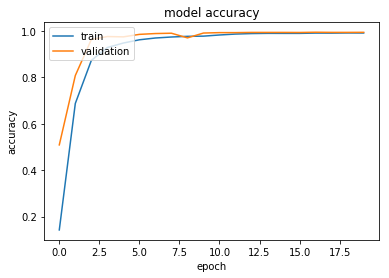

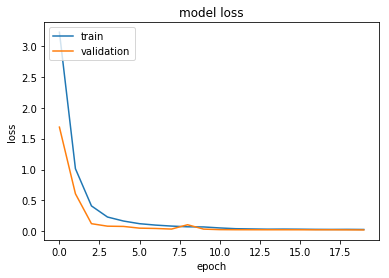

In [16]:
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('acc_f.png', format='png', dpi=300)
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('loss_f.png', format='png', dpi=300)
plt.show()

In [17]:
import pandas as pd
test_info = pd.read_csv('GT-final_test.csv', sep=';')
root_dir = 'gtsrb_testing/'
X_test = []
y_test = []
for file_name, class_id  in zip(list(test_info['Filename']), list(test_info['ClassId'])):
    img_path = os.path.join('gtsrb_testing/',file_name)
    X_test.append(preprocess_img(io.imread(img_path)))
    y_test.append(class_id)
    if len(X_test)%1000 == 0: print("Processed {0}".format(len(X_test)))


X_test = np.array(X_test)
y_test = np.array(y_test)

/home/allenhsu/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Processed 1000
Processed 2000
Processed 3000
Processed 4000
Processed 5000
Processed 6000
Processed 7000
Processed 8000
Processed 9000
Processed 10000
Processed 11000
Processed 12000


In [18]:
y_pred = model.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9642121931908155


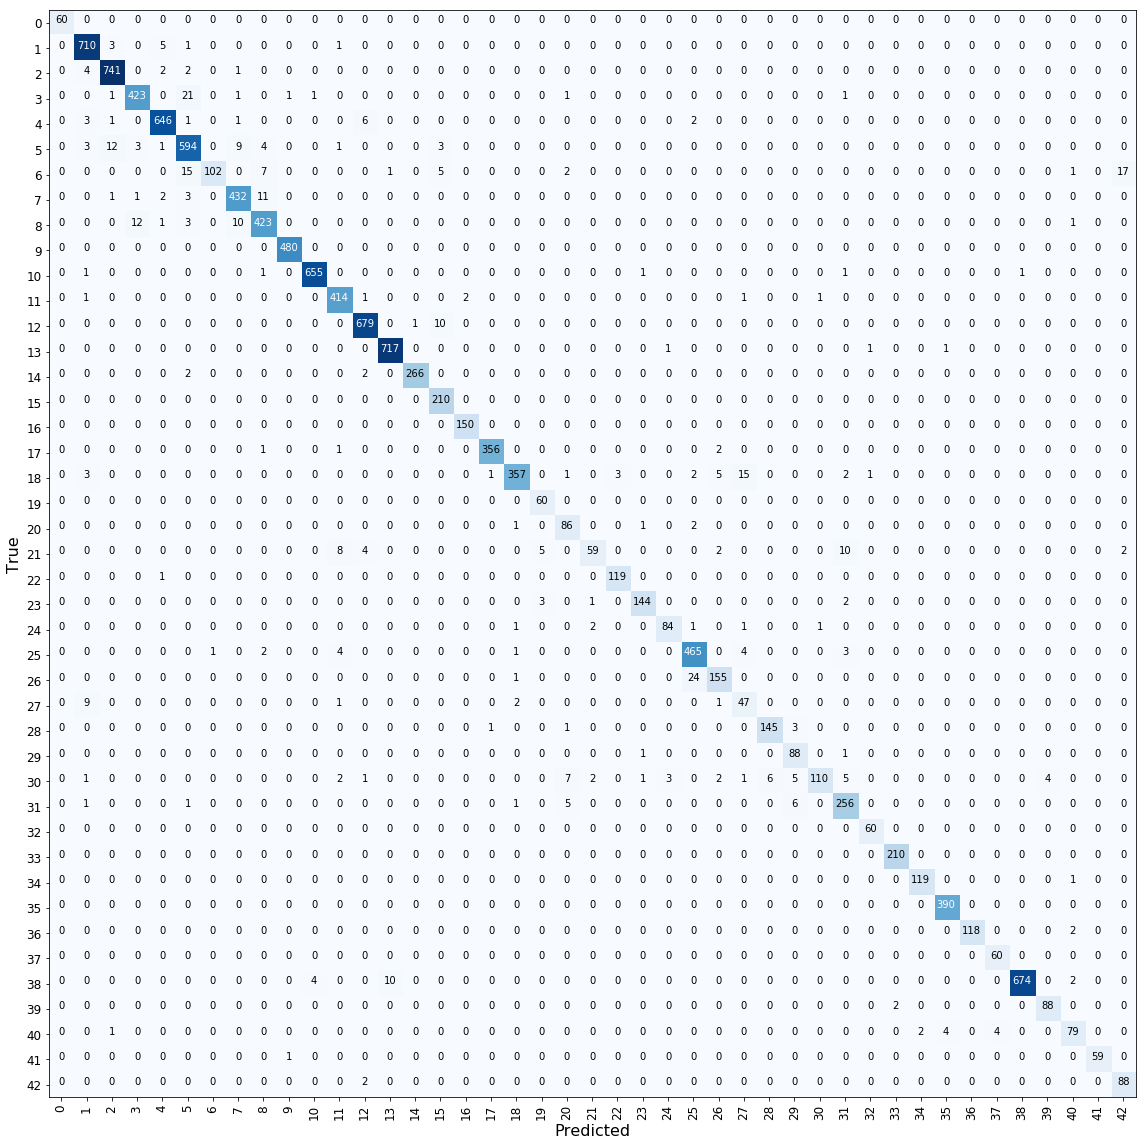

In [19]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))  
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(range(NUM_CLASSES))
plt.yticks(range(NUM_CLASSES))
plt.xticks(rotation= 90)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('True', fontsize= 16)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.savefig('confusion_matrix.png', format='png', dpi=300)
plt.show()


## Train with augmented dataset

Using ImageDataGenerator to augment the training data  
*  Sample-wise standardization  
* Feature-wise standardization  
* ZCA whitening  
* Random rotation, shifts, shear and flips  
* Dimension reordering  


In [20]:
from sklearn.cross_validation import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

datagen = ImageDataGenerator(featurewise_center=False, 
                             featurewise_std_normalization=False, 
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2,
                             shear_range=0.1,
                             rotation_range=10.,)

datagen.fit(X_train)

In [21]:
model_aug = cnn_model()
lr = 0.01
sgd = SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
model_aug.compile(loss='categorical_crossentropy',
          optimizer=sgd,
          metrics=['accuracy'])


def lr_schedule(epoch):
    return lr*(0.1**int(epoch/10))

In [22]:
nb_epoch = 5
history = model_aug.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0],
                                    epochs=nb_epoch,
                                    validation_data=(X_val, y_val),
                                    callbacks=[LearningRateScheduler(lr_schedule),
                                               ModelCheckpoint('model.h5',save_best_only=True)])

Epoch 1/5
31367/31367 [==============================] - 2104s 67ms/step - loss: 0.1000 - acc: 0.9704 - val_loss: 0.0035 - val_acc: 0.9992
Epoch 2/5
31367/31367 [==============================] - 2097s 67ms/step - loss: 0.0060 - acc: 0.9982 - val_loss: 0.0020 - val_acc: 0.9994
Epoch 3/5
31367/31367 [==============================] - 2101s 67ms/step - loss: 0.0034 - acc: 0.9990 - val_loss: 0.0019 - val_acc: 0.9994
Epoch 4/5
31367/31367 [==============================] - 2111s 67ms/step - loss: 0.0024 - acc: 0.9993 - val_loss: 0.0015 - val_acc: 0.9996
Epoch 5/5
31367/31367 [==============================] - 2122s 68ms/step - loss: 0.0017 - acc: 0.9995 - val_loss: 0.0013 - val_acc: 0.9996


In [23]:
y_pred = model_aug.predict_classes(X_test)
acc = np.sum(y_pred==y_test)/np.size(y_pred)
print("Test accuracy = {}".format(acc))

Test accuracy = 0.9904988123515439


In [24]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 10, 10, 64)        0         
__________

## Training result with plot and confusion matrix

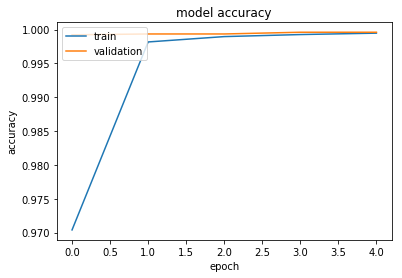

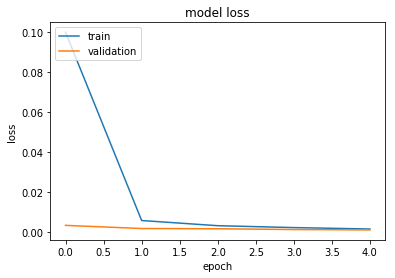

In [27]:
#  "Accuracy"
plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_accuracy.png', format='png', dpi=300)
plt.show()
# "Loss"
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('model_loss.png', format='png', dpi=300)
plt.show()

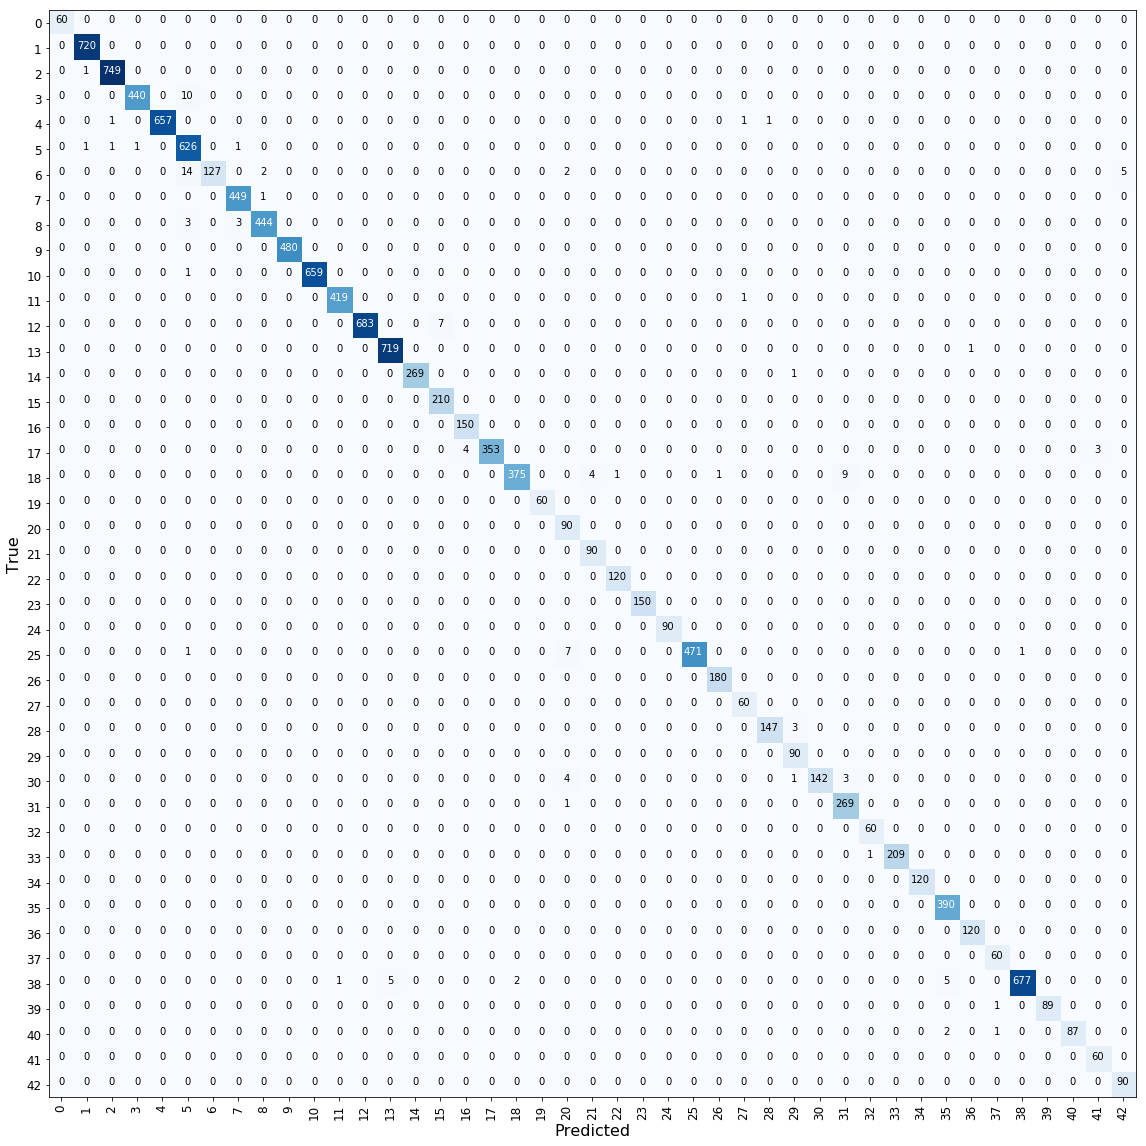

In [29]:
from sklearn.metrics import confusion_matrix
import itertools
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(20,20))  
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(NUM_CLASSES)

plt.xticks(range(NUM_CLASSES))
plt.yticks(range(NUM_CLASSES))
plt.xticks(rotation=90)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.xlabel('Predicted', fontsize = 16)
plt.ylabel('True', fontsize= 16)
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")
plt.savefig('confusion_matrix.png',  format='png', dpi=300)
plt.show()


## Save the model and convert the Keras model into coreML for iOS

In [24]:
model_aug.save("traffic_sign_classifier_model.h5")

In [5]:
model_aug = load_model("traffic_sign_classifier_model.h5")

In [6]:
import coremltools
coreml_model = coremltools.converters.keras.convert(model_aug, input_names='image',
                                                    image_input_names='image',
                                                    image_scale=1/255.0,
                                                    class_labels=['speedLimit25', 'speedLimit30', 'speedLimit35', 'speedLimit40', 'speedLimit45', 'speedLimit50', 'speedLimit55', 'speedLimit65', 'stop', 'stopAhead', 'slow', 'pedestrianCrossing', 'school', 'schoolSpeedLimit25'])
#                                                     class_labels=[i for i in range(14)])
coreml_model.save('traffic_sign_classifier_model.mlmodel')

0 : conv2d_21_input, <keras.engine.topology.InputLayer object at 0x7f969e0edb38>
1 : conv2d_21, <keras.layers.convolutional.Conv2D object at 0x7f969e0ed748>
2 : conv2d_21__activation__, <keras.layers.core.Activation object at 0x7f96ae298208>
3 : conv2d_22, <keras.layers.convolutional.Conv2D object at 0x7f969e0edda0>
4 : conv2d_22__activation__, <keras.layers.core.Activation object at 0x7f96ae298470>
5 : max_pooling2d_11, <keras.layers.pooling.MaxPooling2D object at 0x7f969e0edc88>
6 : conv2d_23, <keras.layers.convolutional.Conv2D object at 0x7f969e09f400>
7 : conv2d_23__activation__, <keras.layers.core.Activation object at 0x7f96ae2984e0>
8 : conv2d_24, <keras.layers.convolutional.Conv2D object at 0x7f969e08e4a8>
9 : conv2d_24__activation__, <keras.layers.core.Activation object at 0x7f96ae2983c8>
10 : max_pooling2d_12, <keras.layers.pooling.MaxPooling2D object at 0x7f969e0bcb00>
11 : conv2d_25, <keras.layers.convolutional.Conv2D object at 0x7f969e05cf98>
12 : conv2d_25__activation__, <